# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The ToTensor transform converts the pixel data to tensor which the model can interpret.  
The Normalize transform then brings the image data within the range of [-1, 1]

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


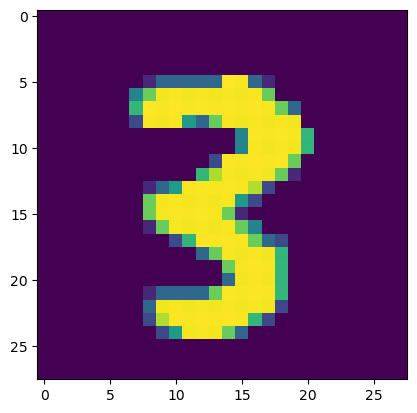

4


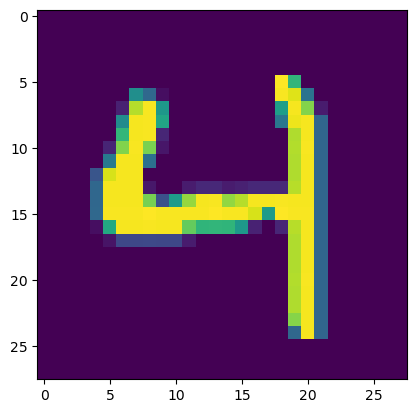

5


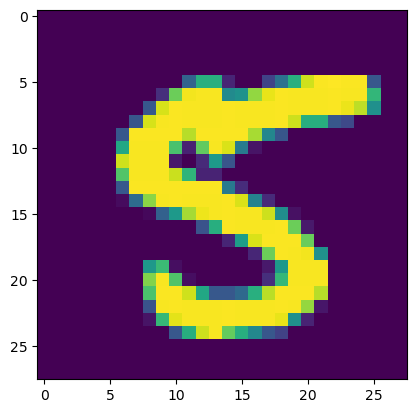

4


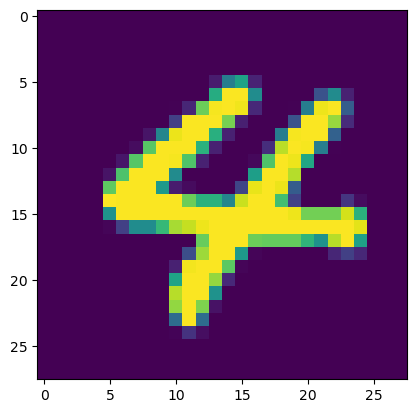

4


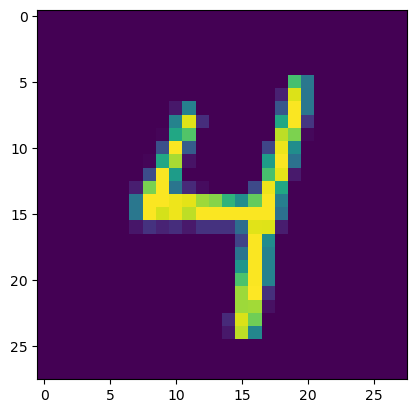

In [4]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Flatten layer
        self.flat = nn.Flatten()
        
        # Input layer to Hidden Layer 1
        self.fc1 = nn.Linear(784, 128)
        
        # Hidden Layer 1 to Hidden Layer 2
        self.fc2 = nn.Linear(128, 64)
        
        # Hidden Layer 2 to Output Layer
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Flatten layer
        x = self.flat(x)

        # Hidden Layer 1 ReLU activation
        x = F.relu(self.fc1(x))
        
        # Hidden Layer 2 ReLU activation
        x = F.relu(self.fc2(x))
        
        # Output Layer Softmax activation
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
torch.cuda.is_available()

True

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
model.to(device)

Network(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Plot the training loss (and validation loss/accuracy, if recorded).

In [10]:
num_epochs = 5

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 45.45% training loss: -0.69770
Epoch 1 validation accuracy: 48.87% validation loss: -0.76354
Epoch 2 training accuracy: 49.00% training loss: -0.76310
Epoch 2 validation accuracy: 51.37% validation loss: -0.80131
Epoch 3 training accuracy: 53.74% training loss: -0.83683
Epoch 3 validation accuracy: 53.57% validation loss: -0.83772
Epoch 4 training accuracy: 54.79% training loss: -0.85396
Epoch 4 validation accuracy: 54.86% validation loss: -0.85935
Epoch 5 training accuracy: 55.15% training loss: -0.86004
Epoch 5 validation accuracy: 54.99% validation loss: -0.86170


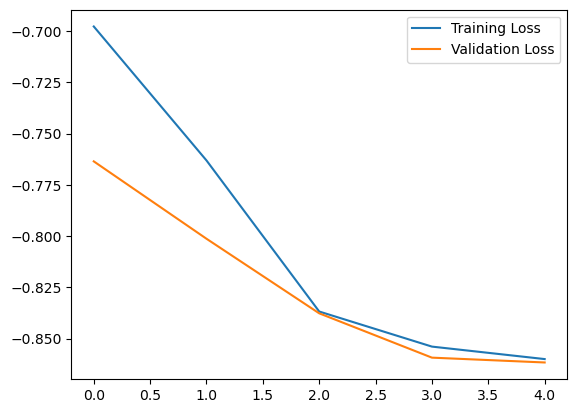

In [11]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
test_loss = 0
accuracy = 0
model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        log_ps = model.forward(inputs)
        batch_loss = criterion(log_ps, labels)
                    
        test_loss += batch_loss.item()
                    
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test accuracy: 0.864


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [13]:
model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

Network(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [14]:
num_epochs = 150

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

# Early stopping parameters
early_stop_thresh = 5
best_accuracy = -1
best_epoch = -1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()

    accuracy = val_correct/len(test_loader)

    print(f'Epoch {epoch + 1} validation accuracy: {accuracy:.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_epoch = epoch
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # Terminate the training

Epoch 1 training accuracy: 54.11% training loss: 1.63123
Epoch 1 validation accuracy: 58.24% validation loss: 1.55124
Epoch 2 training accuracy: 58.72% training loss: 1.54655
Epoch 2 validation accuracy: 58.78% validation loss: 1.54210
Epoch 3 training accuracy: 59.53% training loss: 1.53262
Epoch 3 validation accuracy: 59.99% validation loss: 1.52128
Epoch 4 training accuracy: 60.27% training loss: 1.52099
Epoch 4 validation accuracy: 60.11% validation loss: 1.51934
Epoch 5 training accuracy: 60.66% training loss: 1.51424
Epoch 5 validation accuracy: 60.56% validation loss: 1.51162
Epoch 6 training accuracy: 60.99% training loss: 1.50883
Epoch 6 validation accuracy: 60.50% validation loss: 1.51184
Epoch 7 training accuracy: 61.20% training loss: 1.50503
Epoch 7 validation accuracy: 60.71% validation loss: 1.50916
Epoch 8 training accuracy: 61.28% training loss: 1.50364
Epoch 8 validation accuracy: 60.90% validation loss: 1.50515
Epoch 9 training accuracy: 61.54% training loss: 1.49990

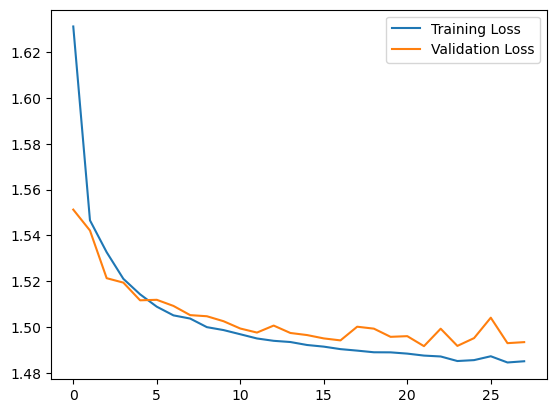

In [15]:
# Plot the new training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [16]:
# Print accuracy of new model
test_loss = 0
accuracy = 0
model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        log_ps = model.forward(inputs)
        batch_loss = criterion(log_ps, labels)
                    
        test_loss += batch_loss.item()
                    
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test accuracy: 0.968


## Further improvement

In [19]:
model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.to(device)

Network(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [20]:
num_epochs = 500

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

# Early stopping parameters
early_stop_thresh = 20
best_accuracy = -1
best_epoch = -1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()

    accuracy = val_correct/len(test_loader)

    print(f'Epoch {epoch + 1} validation accuracy: {accuracy:.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_epoch = epoch
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # Terminate the training

Epoch 1 training accuracy: 45.44% training loss: 1.81454
Epoch 1 validation accuracy: 53.02% validation loss: 1.65478
Epoch 2 training accuracy: 53.28% training loss: 1.64597
Epoch 2 validation accuracy: 53.67% validation loss: 1.63041
Epoch 3 training accuracy: 55.38% training loss: 1.61061
Epoch 3 validation accuracy: 57.71% validation loss: 1.57140
Epoch 4 training accuracy: 58.11% training loss: 1.56689
Epoch 4 validation accuracy: 58.24% validation loss: 1.55712
Epoch 5 training accuracy: 58.61% training loss: 1.55605
Epoch 5 validation accuracy: 58.45% validation loss: 1.55207
Epoch 6 training accuracy: 58.86% training loss: 1.54971
Epoch 6 validation accuracy: 58.96% validation loss: 1.54434
Epoch 7 training accuracy: 59.17% training loss: 1.54456
Epoch 7 validation accuracy: 59.07% validation loss: 1.54027
Epoch 8 training accuracy: 59.37% training loss: 1.54048
Epoch 8 validation accuracy: 59.15% validation loss: 1.53860
Epoch 9 training accuracy: 59.59% training loss: 1.53669

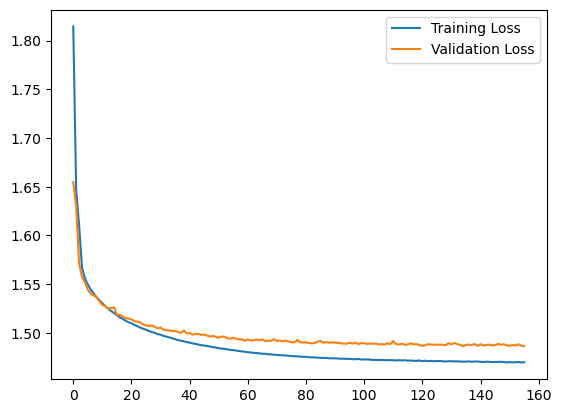

In [21]:
# Plot the new training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [22]:
# Print accuracy of new model
test_loss = 0
accuracy = 0
model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        log_ps = model.forward(inputs)
        batch_loss = criterion(log_ps, labels)
                    
        test_loss += batch_loss.item()
                    
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test accuracy: 0.974


## Saving your model
Using `torch.save`, save your model for future loading.

In [23]:
torch.save(model, 'mnist_digits_2.pth')